In [40]:
import itertools

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from kaggle.api.kaggle_api_extended import KaggleApi
import numpy as np

In [3]:
sns.set_style("dark")
plt.style.use("dark_background")

In [4]:
api = KaggleApi()
api.authenticate()

dataset = "kabure/german-credit-data-with-risk" 
api.dataset_download_files(dataset, path=".", unzip=True)

Dataset URL: https://www.kaggle.com/datasets/kabure/german-credit-data-with-risk


In [6]:
df = pd.read_csv("german_credit_data.csv", index_col=0)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [17]:
# Standardize column names: strip spaces, replace special characters, and convert to lowercase
df.columns = (
    df.columns.str.strip()  # Remove leading/trailing spaces
    .str.lower()  # Convert to lowercase
    .str.replace(r"[^a-z0-9\s]", "", regex=True)  # Remove special characters
    .str.replace("\s+", "_", regex=True)  # Replace spaces with underscores
)

# Display updated column names
df.columns

Index(['age', 'sex', 'job', 'housing', 'saving_accounts', 'checking_account',
       'credit_amount', 'duration', 'purpose', 'risk'],
      dtype='object')

In [18]:
df.shape

(1000, 10)

In [19]:
df.risk.value_counts()

risk
good    700
bad     300
Name: count, dtype: int64

In [20]:
# Splitting the columns
categorical_columns = df.select_dtypes(include=["object"]).columns.tolist()
numerical_columns = df.select_dtypes(exclude=["object"]).columns.tolist()

# Display the lists of columns
print("Categorical Columns:", categorical_columns)
print("Numerical Columns:", numerical_columns)

Categorical Columns: ['sex', 'housing', 'saving_accounts', 'checking_account', 'purpose', 'risk']
Numerical Columns: ['age', 'job', 'credit_amount', 'duration']


## Descriptive Statistics

In [21]:
df[numerical_columns].describe()

,age,job,credit_amount,duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


In [22]:
df[categorical_columns].describe()

,sex,housing,saving_accounts,checking_account,purpose,risk
count,1000,1000,817,606,1000,1000
unique,2,3,4,3,8,2
top,male,own,little,little,car,good
freq,690,713,603,274,337,700


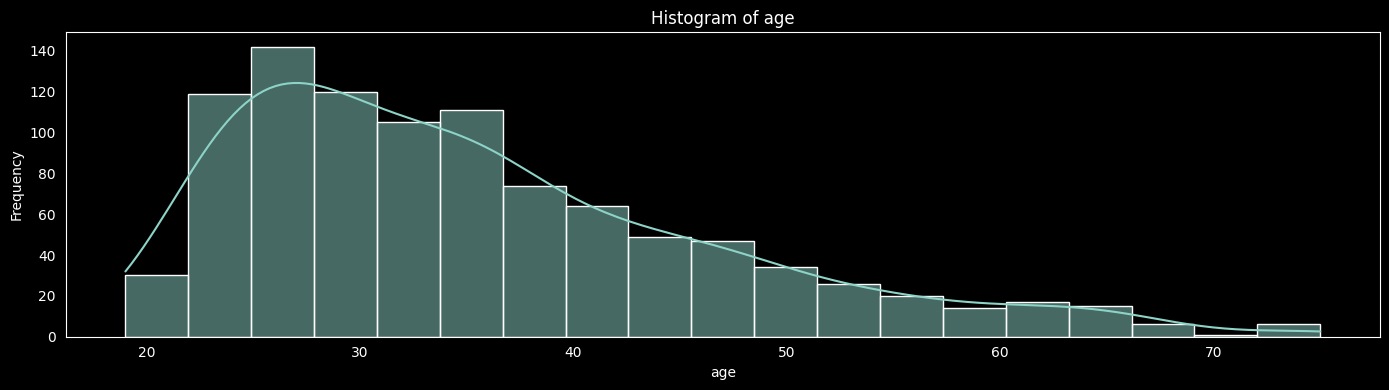

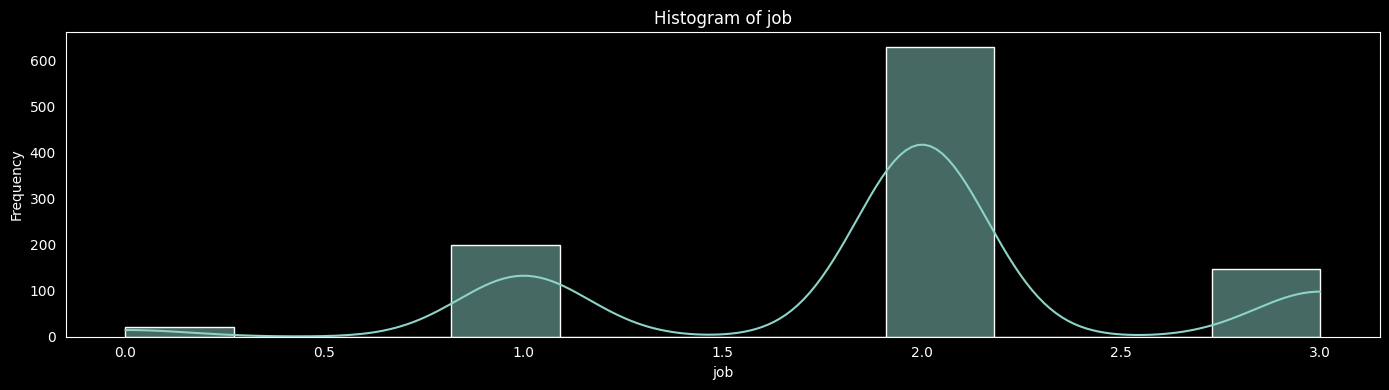

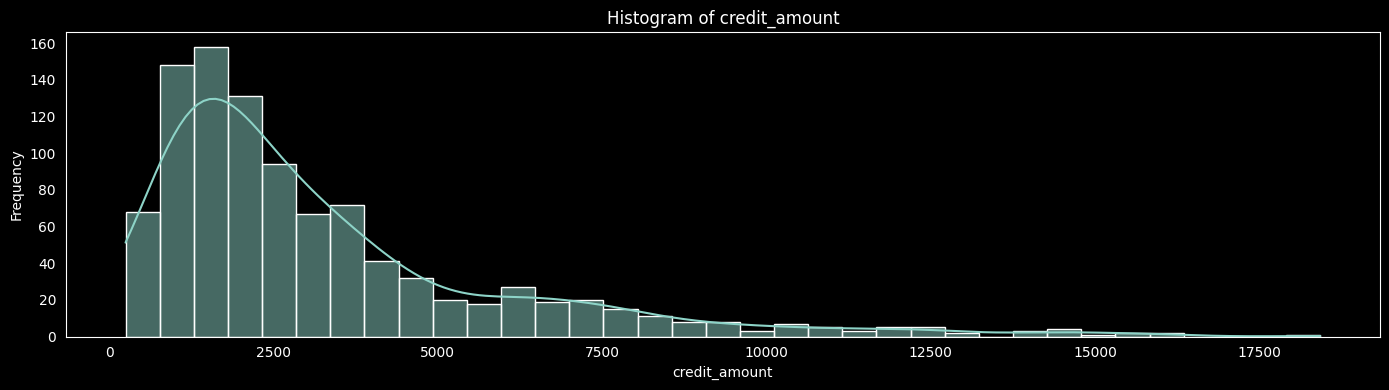

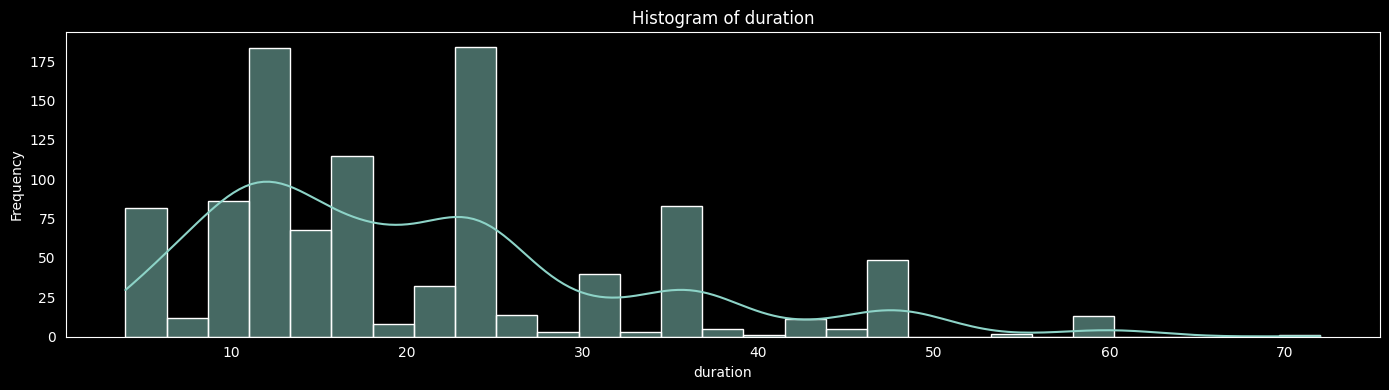

In [23]:
for col in numerical_columns:
    plt.figure(figsize=(14, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

### Summary 
#### Histogram of Age
- The tail is on the right, meaning that the data is right-skewed (positively skewed). 
- Right-skewed distributions have a longer tail on the right, indicating that there are fewer occurrences of higher values compared to lower values.
- Left-skewed (negatively skewed) distributions, on the other hand, have a longer tail on the left, meaning that there are fewer occurrences of lower values and more frequent higher values.

#### Histogram of Job
- A multimodal distribution has more than one peak, meaning that the data has multiple clusters or groups. In this case:

- There's a small peak around 0.
- A larger peak around 1.
- A very large peak around 2.
- Another smaller peak around 3.
- This suggests that the dataset consists of distinct groups of jobs, with job category 2 being the most common. 
- The presence of multiple peaks indicates that the data is not normally distributed and that different subpopulations may exist within the dataset.

#### Historgram of duration
- Irregular peaks, Instead of a smooth distribution, the histogram has distinct spikes at certain values (e.g., around 10 and 25).
- Gaps and dips, Some durations are far less frequent or even missing in between peaks, which isn’t typical for continuous data.
- Multimodal behaviour, There appear to be multiple peaks, suggesting different clusters or patterns in the data.
- These are likely load durations so makes more sense if they are categories rather than continuous values.

In [28]:
# Convert 'job' and 'duration' to categorical
df2 = df.copy()
df2["job"] = df2["job"].astype("object")
# df2["duration"] = df2["duration"].astype("object")

# Re-split the columns
categorical_columns = df2.select_dtypes(include=["object"]).columns.tolist()
numerical_columns = df2.select_dtypes(exclude=["object"]).columns.tolist()

print("Categorical Columns:", categorical_columns)
print("Numerical Columns:", numerical_columns)

Categorical Columns: ['sex', 'job', 'housing', 'saving_accounts', 'checking_account', 'purpose', 'risk']
Numerical Columns: ['age', 'credit_amount', 'duration']


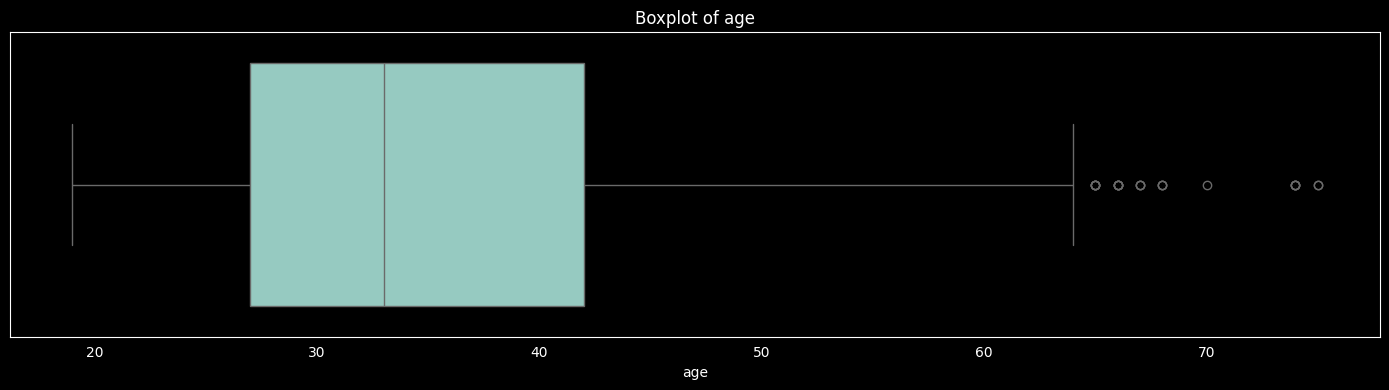

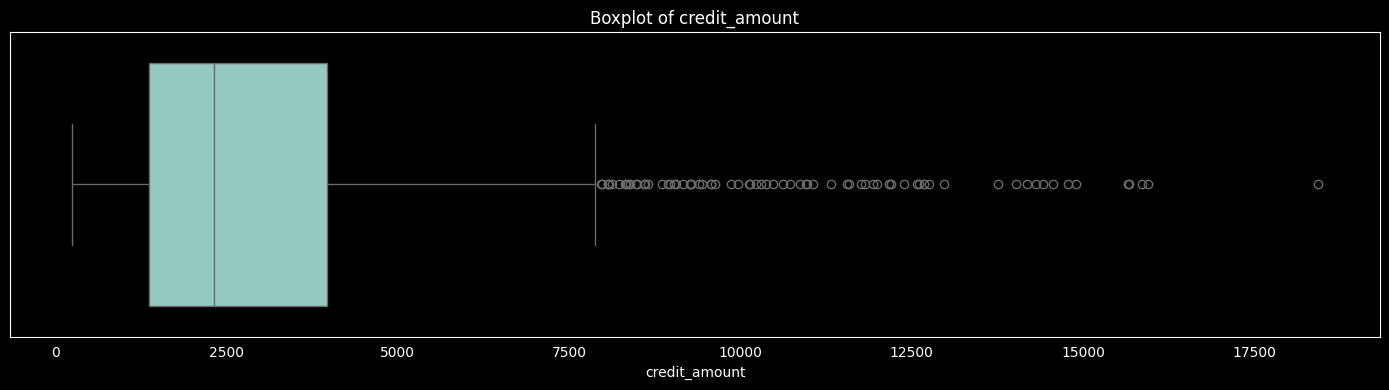

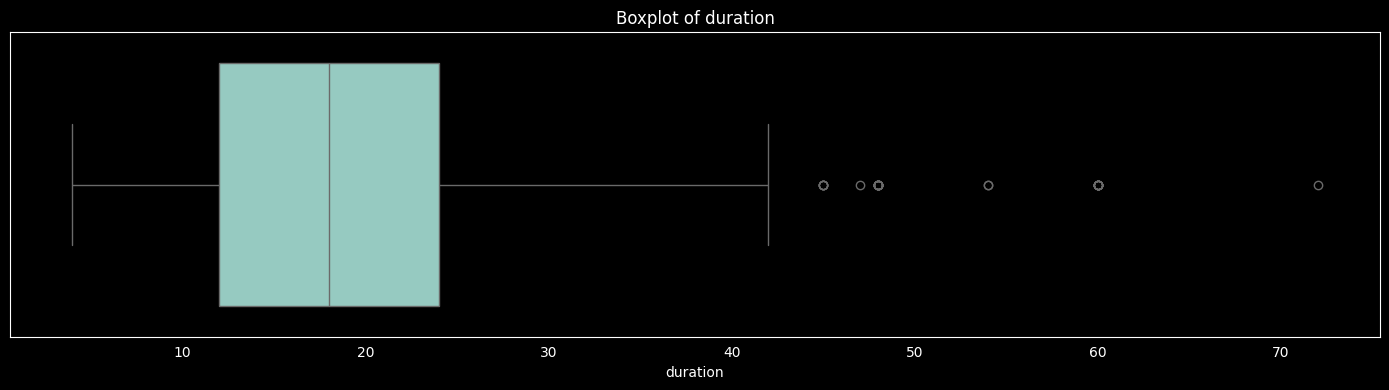

In [29]:
for col in numerical_columns:
    plt.figure(figsize=(14, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

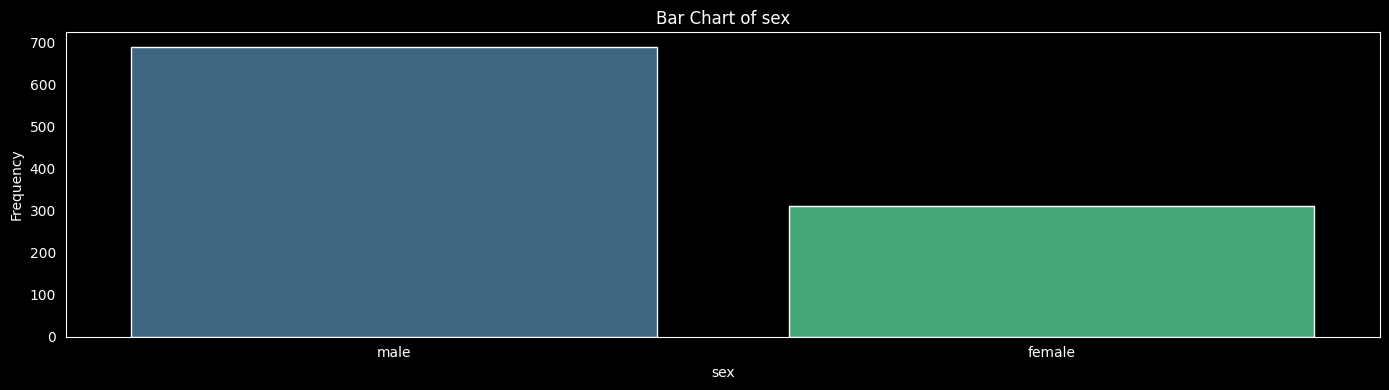

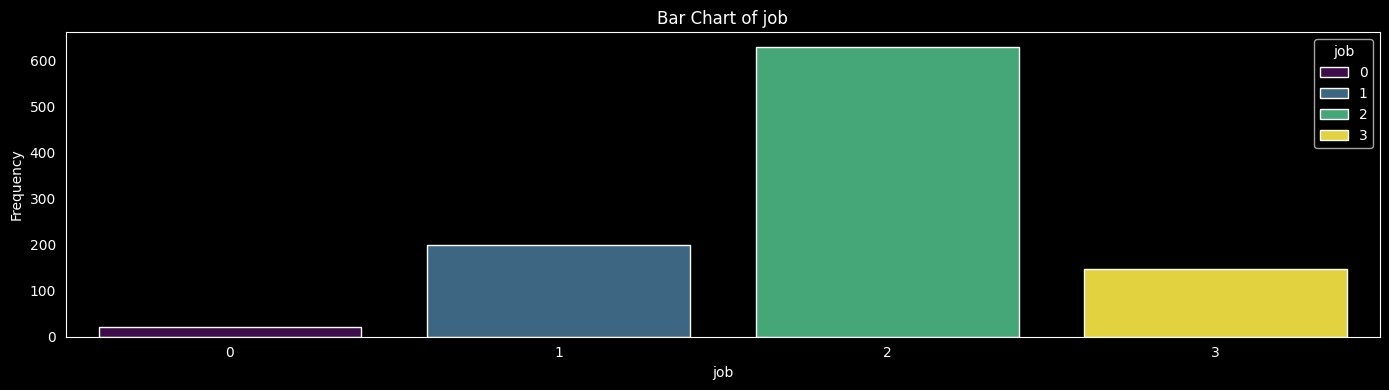

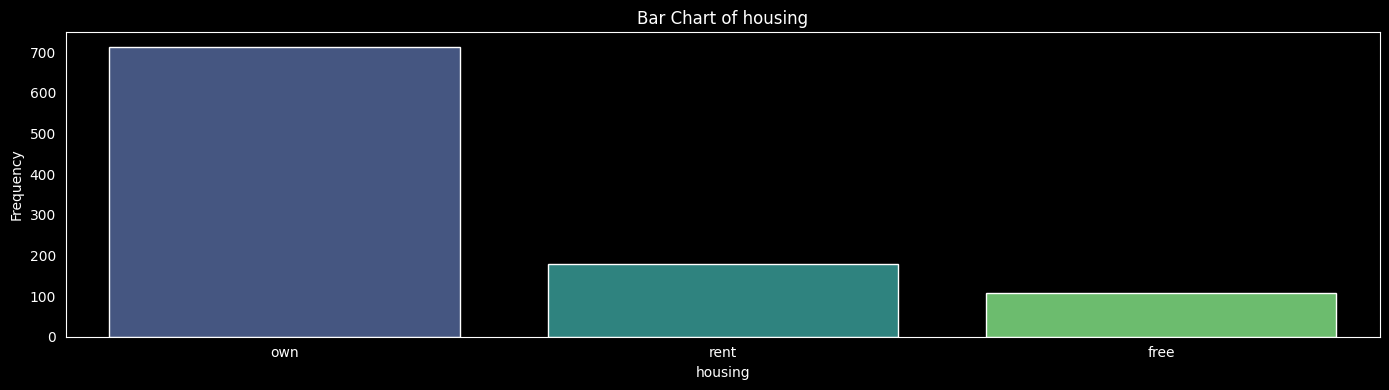

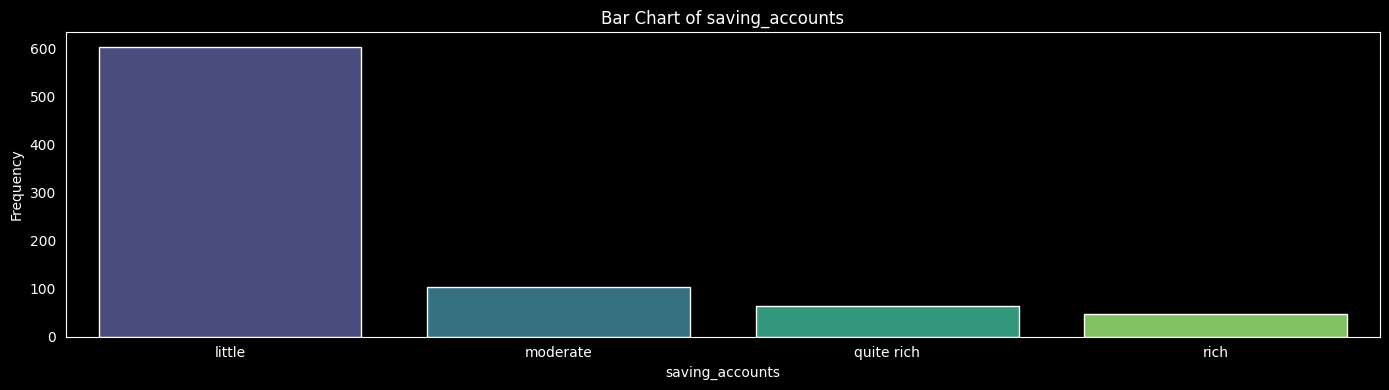

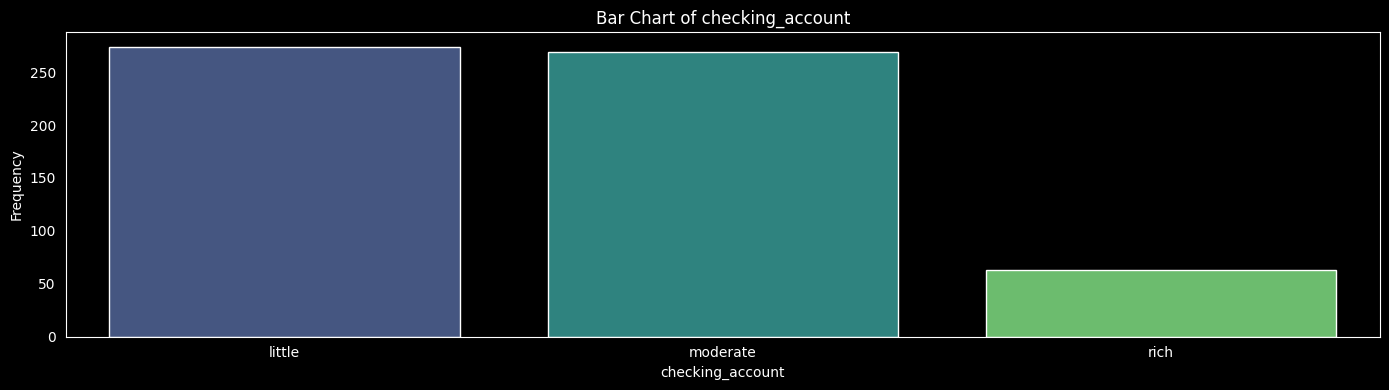

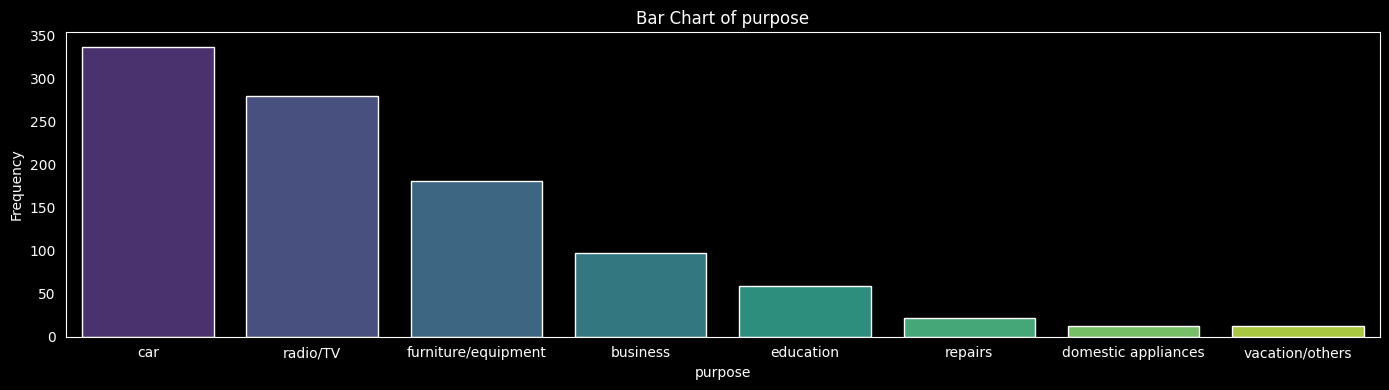

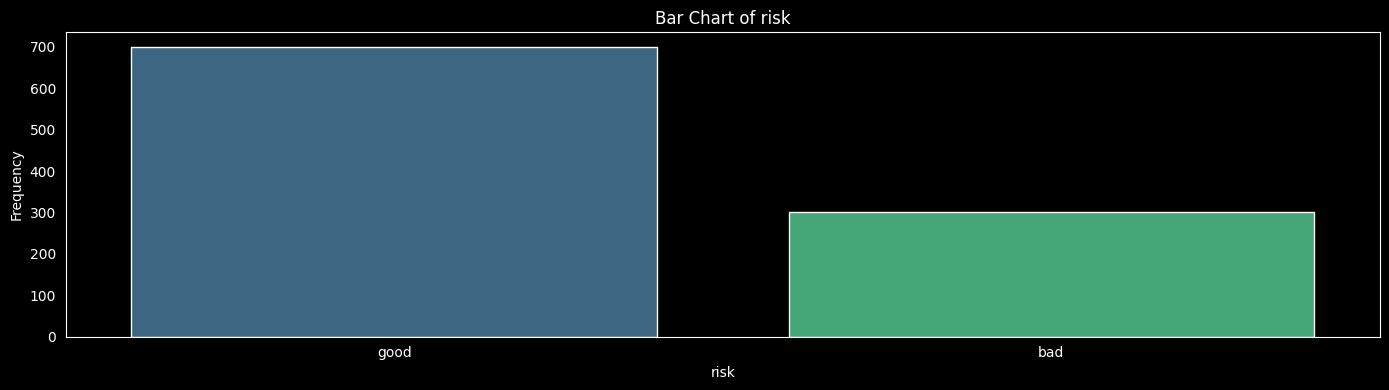

In [31]:
for col in categorical_columns:
    plt.figure(figsize=(14, 4))
    counts = df[col].value_counts()
    sns.barplot(x=counts.index, y=counts.values, hue=counts.index, palette="viridis")
    plt.title(f"Bar Chart of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    # plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

### Bivariate Analysis

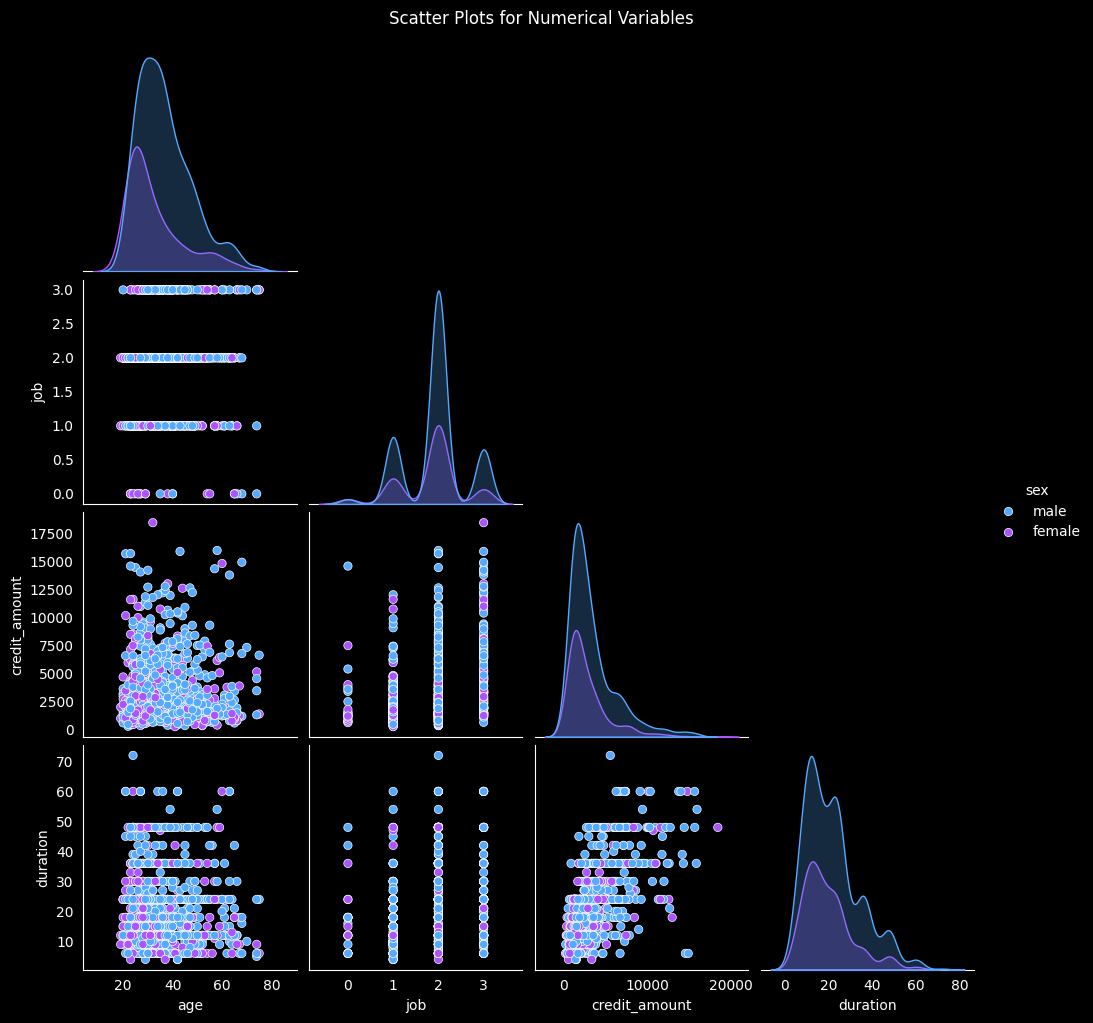

In [32]:
sns.pairplot(
    diag_kind="kde",
    hue="sex",
    palette="cool",
    corner=True,
    data=df2,
)
plt.suptitle("Scatter Plots for Numerical Variables", y=1.02)
plt.show()

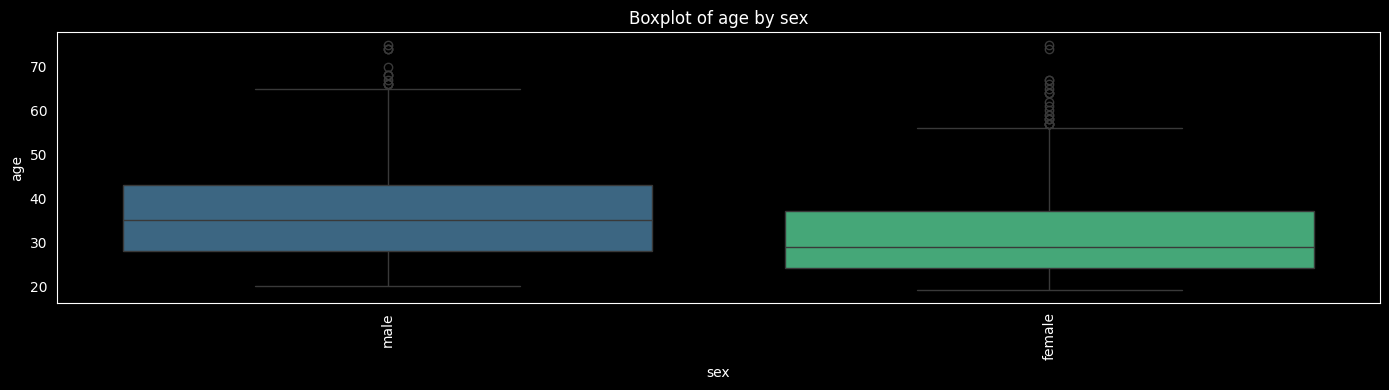

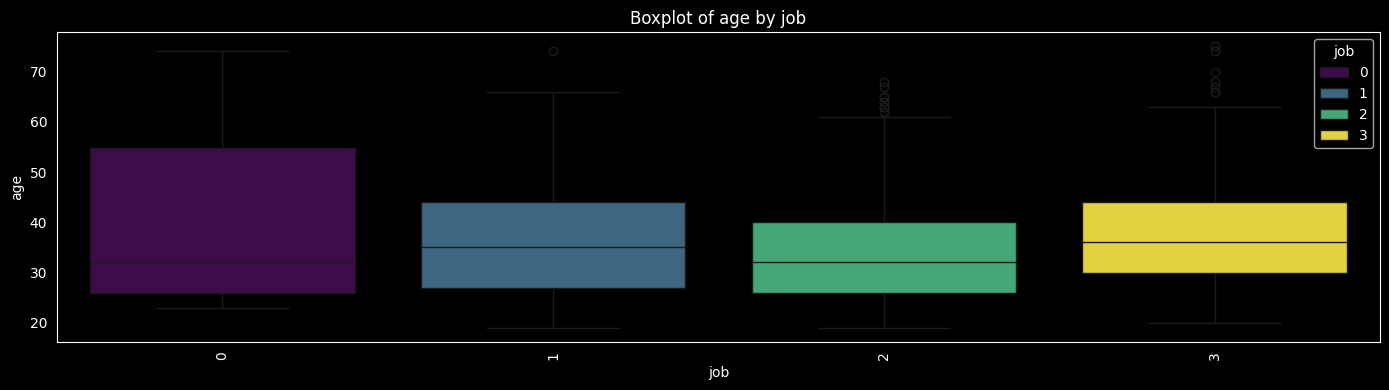

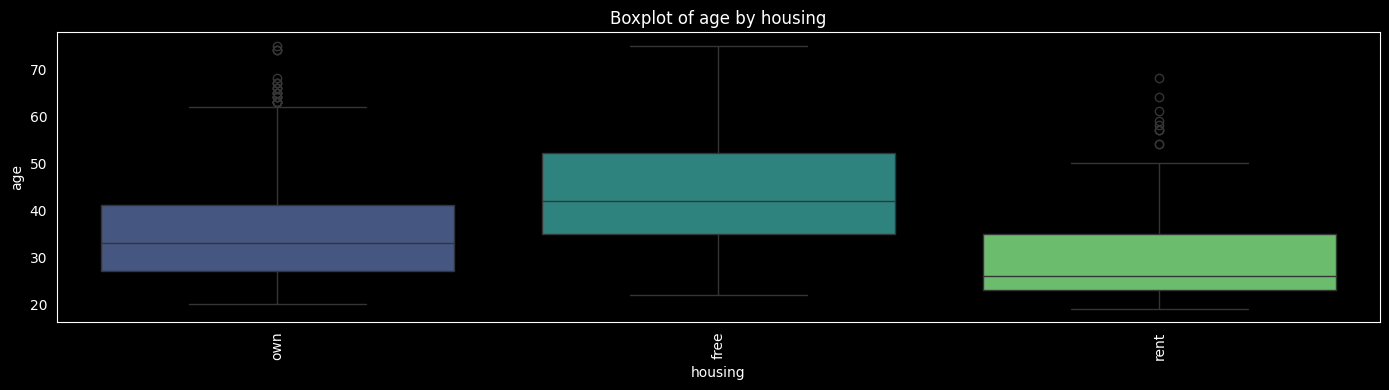

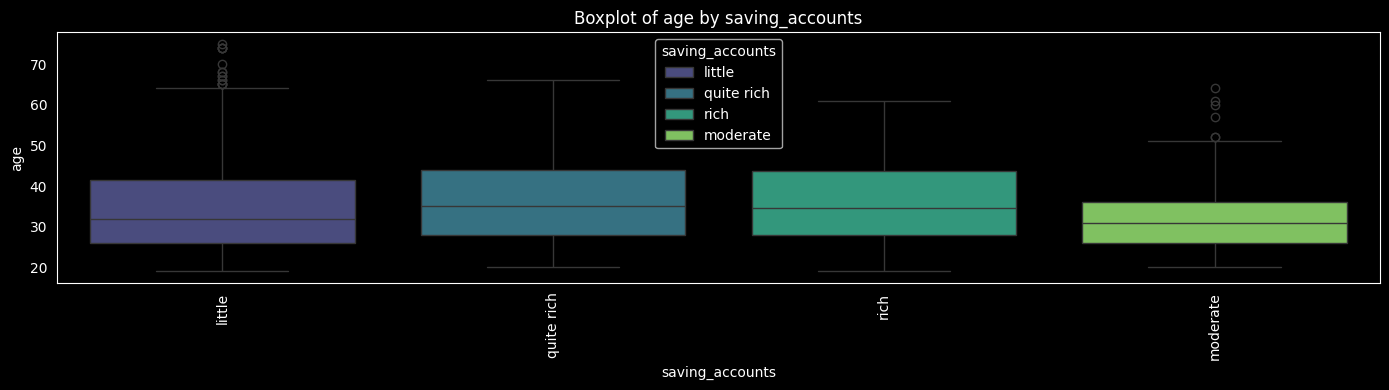

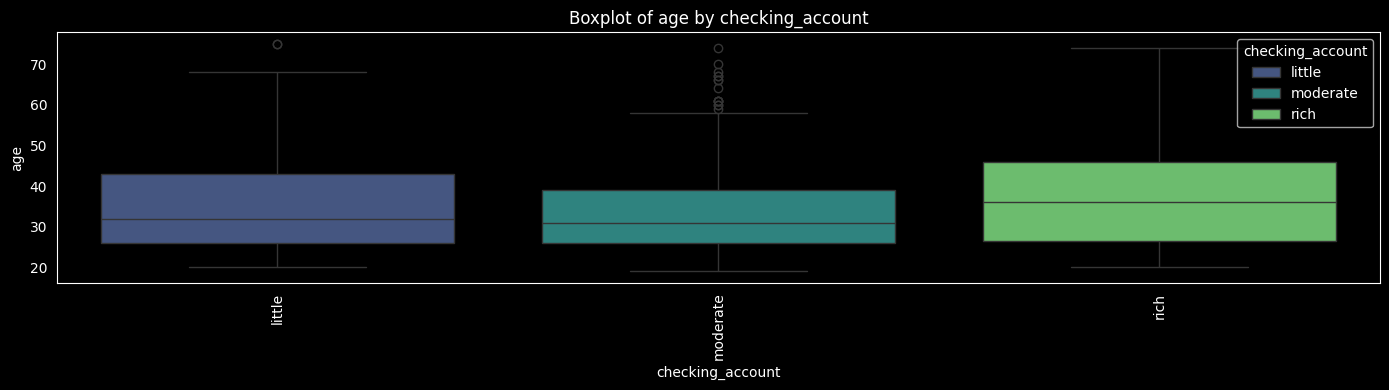

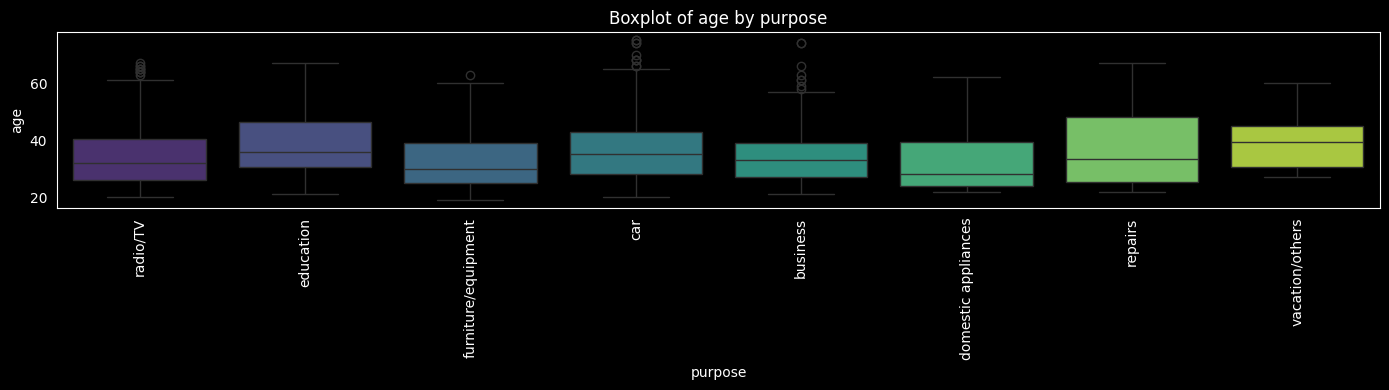

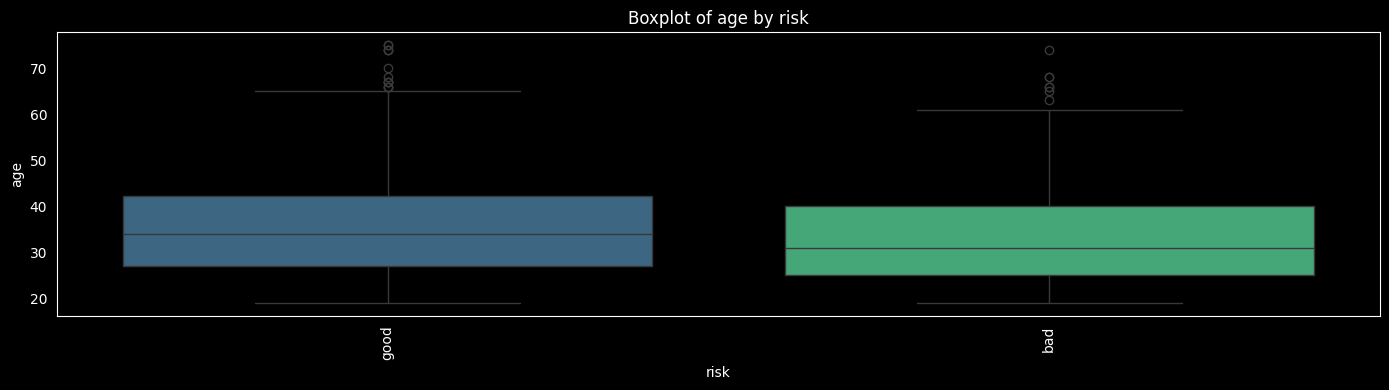

In [34]:
selected_numerical = "age"
for idx, cat in enumerate(categorical_columns):
    plt.figure(figsize=(14, 4))
    sns.boxplot(x=df2[cat], y=df2[selected_numerical], hue=df2[cat], palette="viridis")
    plt.title(f"Boxplot of {selected_numerical} by {cat}")
    plt.xlabel(cat)
    plt.ylabel(selected_numerical)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

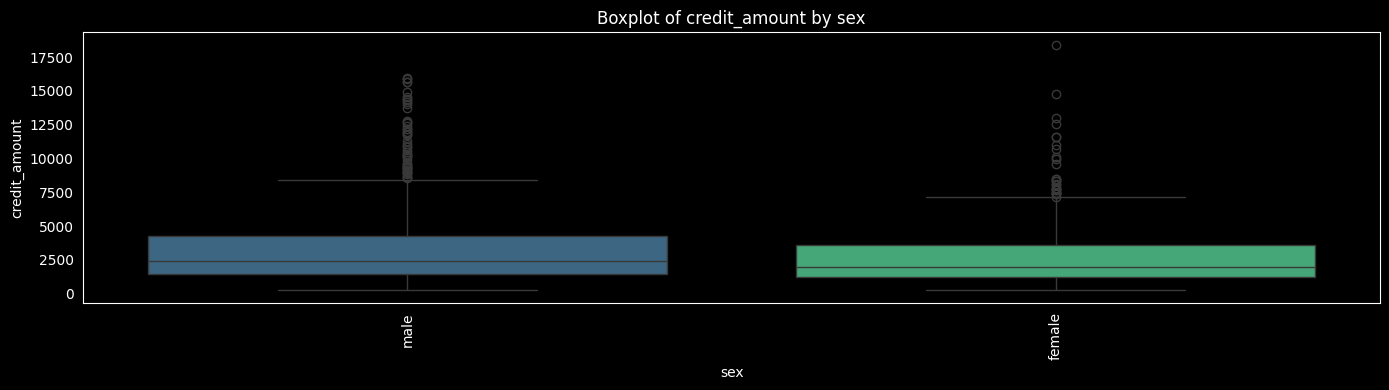

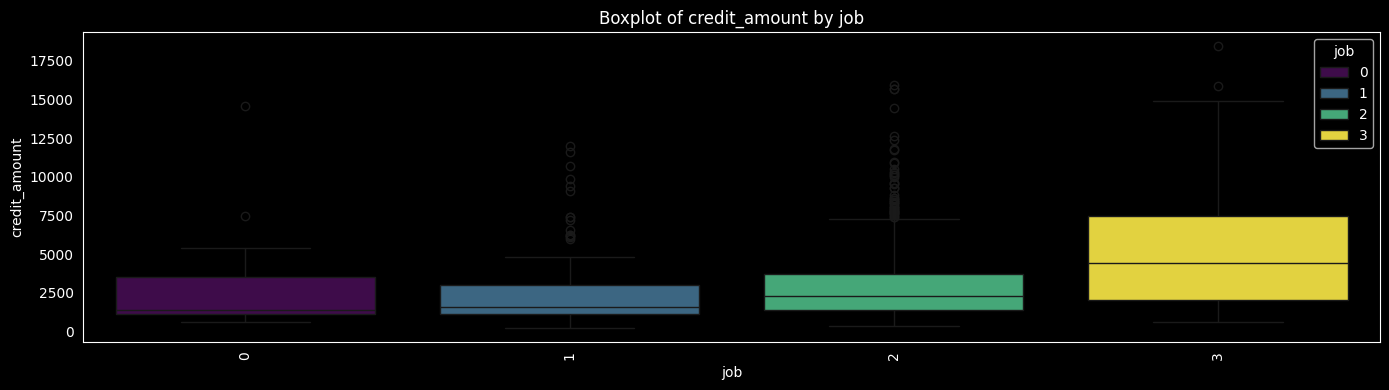

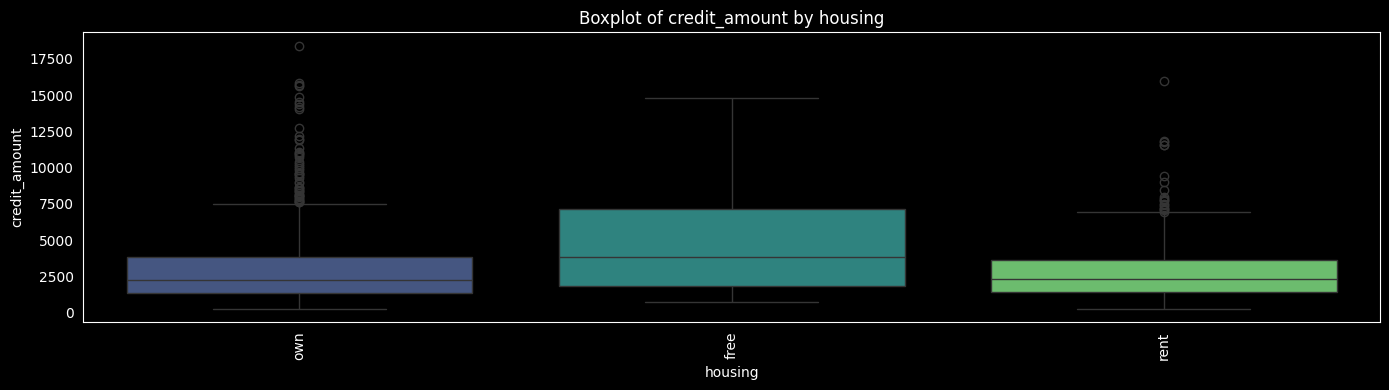

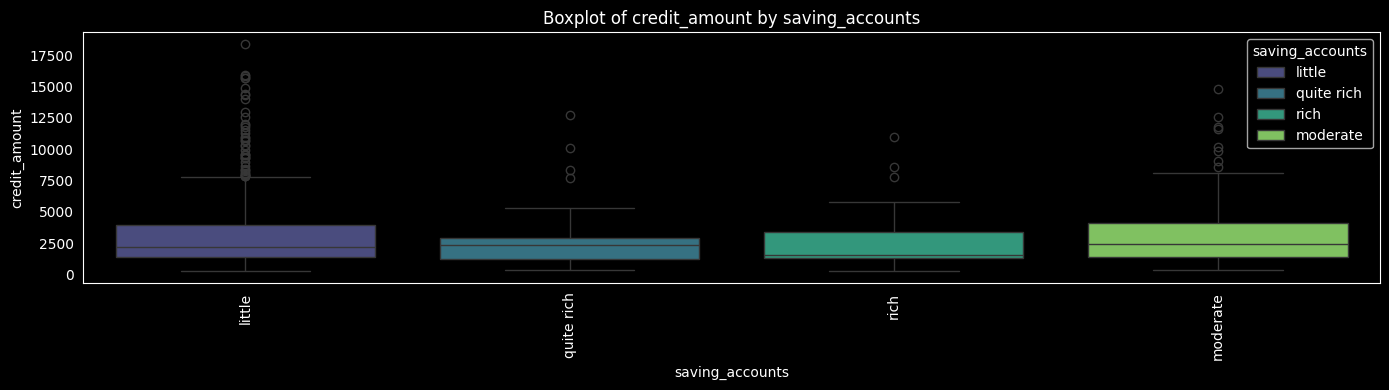

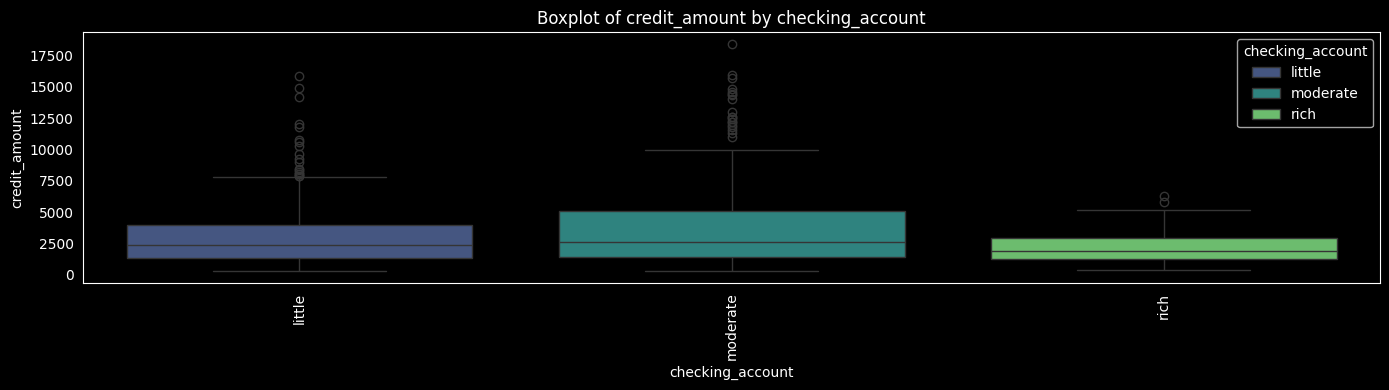

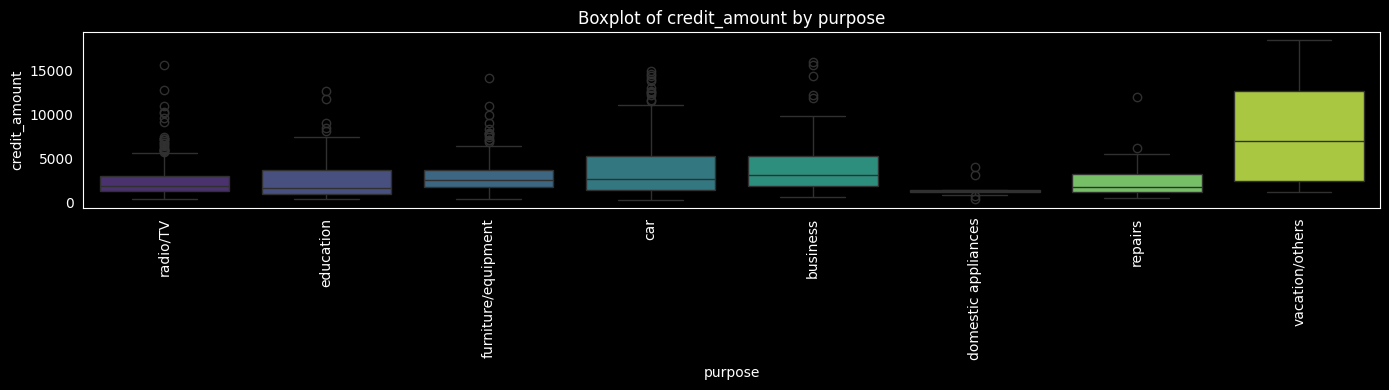

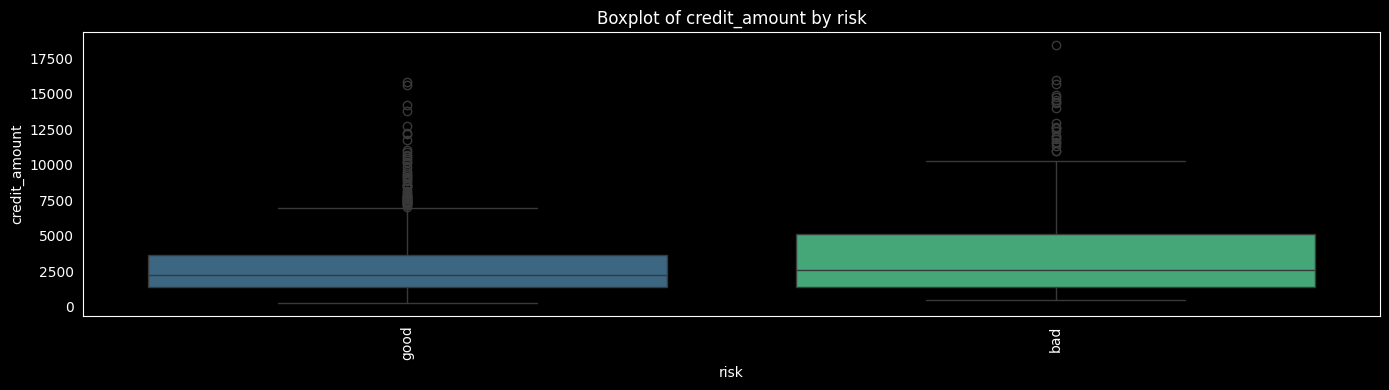

In [35]:
selected_numerical = "credit_amount"
for idx, cat in enumerate(categorical_columns):
    plt.figure(figsize=(14, 4))
    sns.boxplot(x=df2[cat], y=df2[selected_numerical], hue=df2[cat], palette="viridis")
    plt.title(f"Boxplot of {selected_numerical} by {cat}")
    plt.xlabel(cat)
    plt.ylabel(selected_numerical)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [36]:
categorical_columns

['sex',
 'job',
 'housing',
 'saving_accounts',
 'checking_account',
 'purpose',
 'risk']

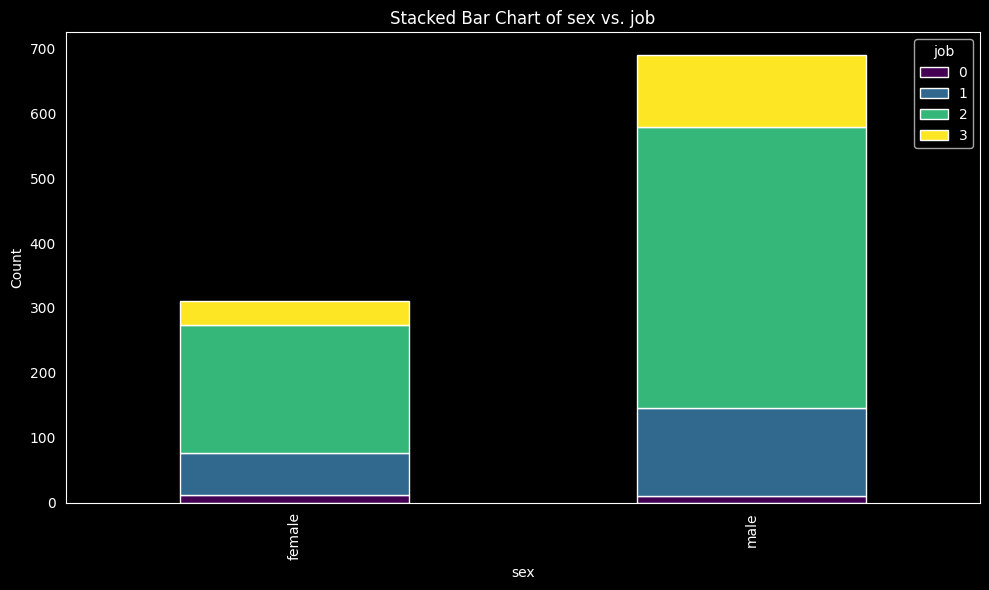

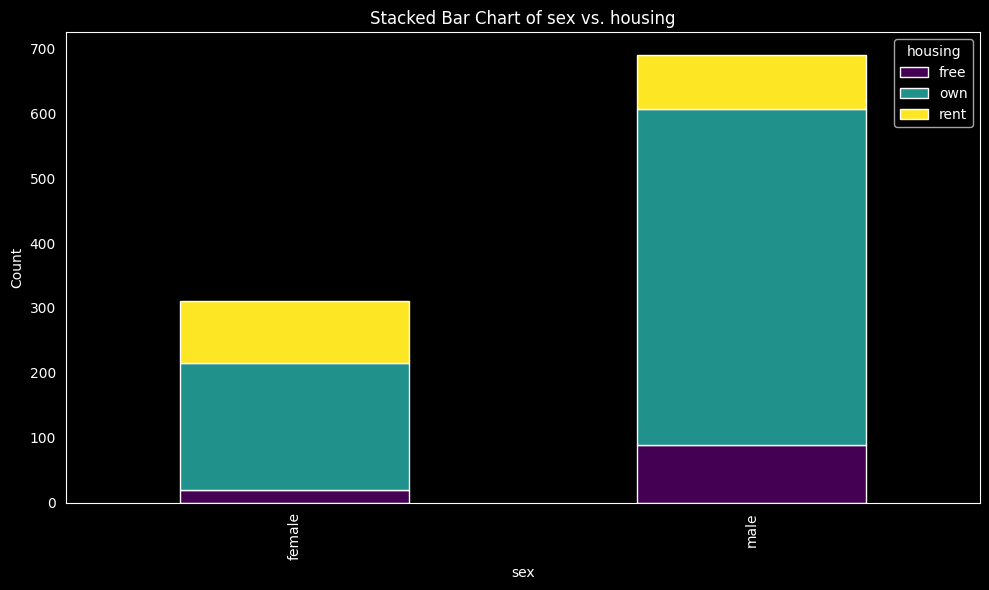

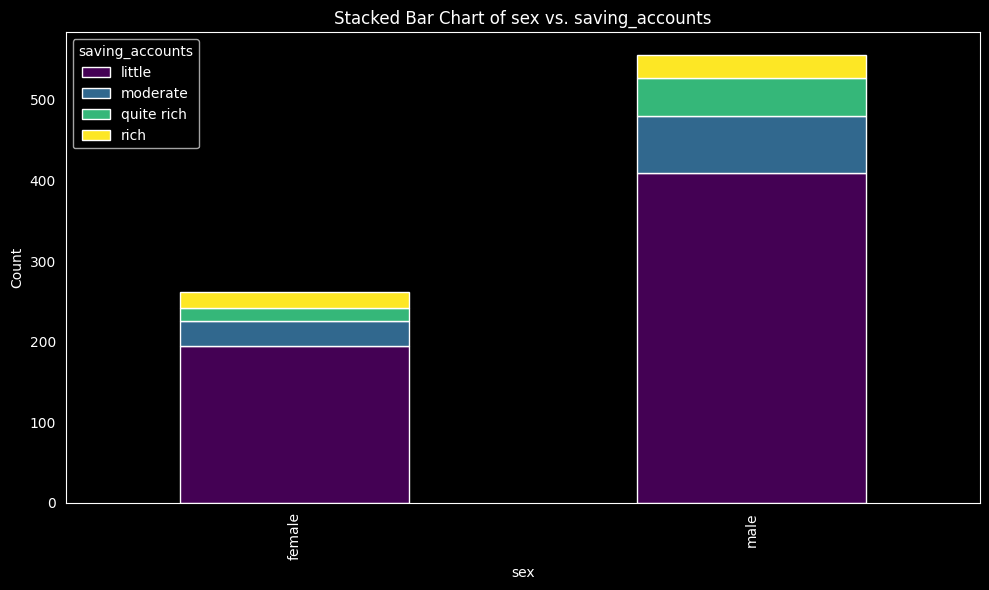

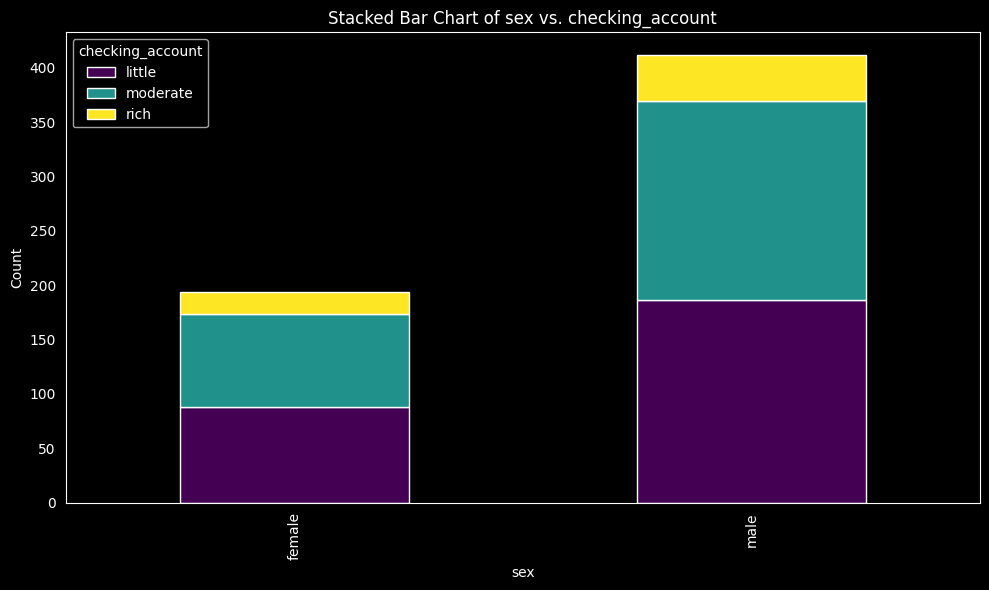

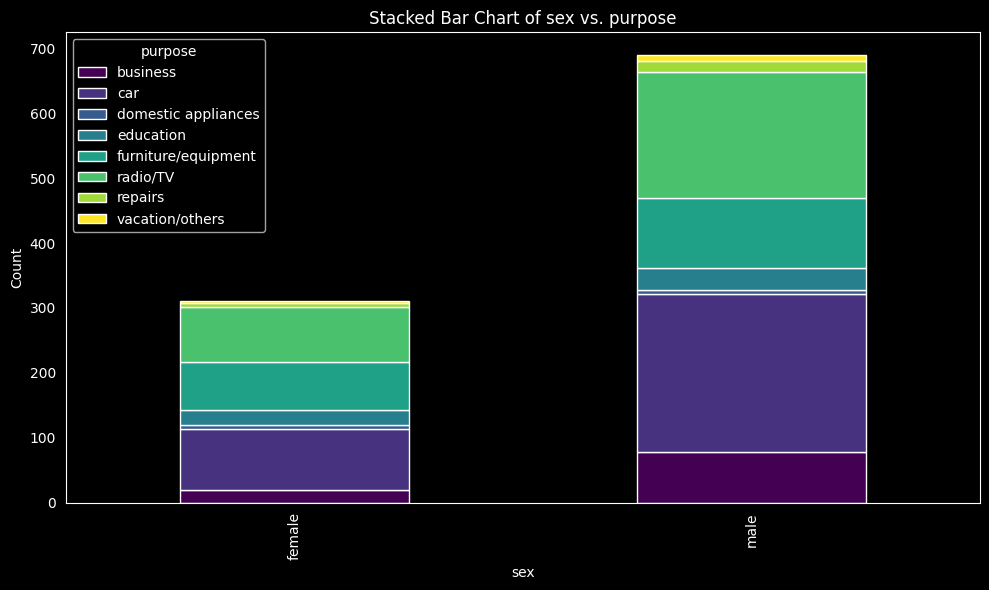

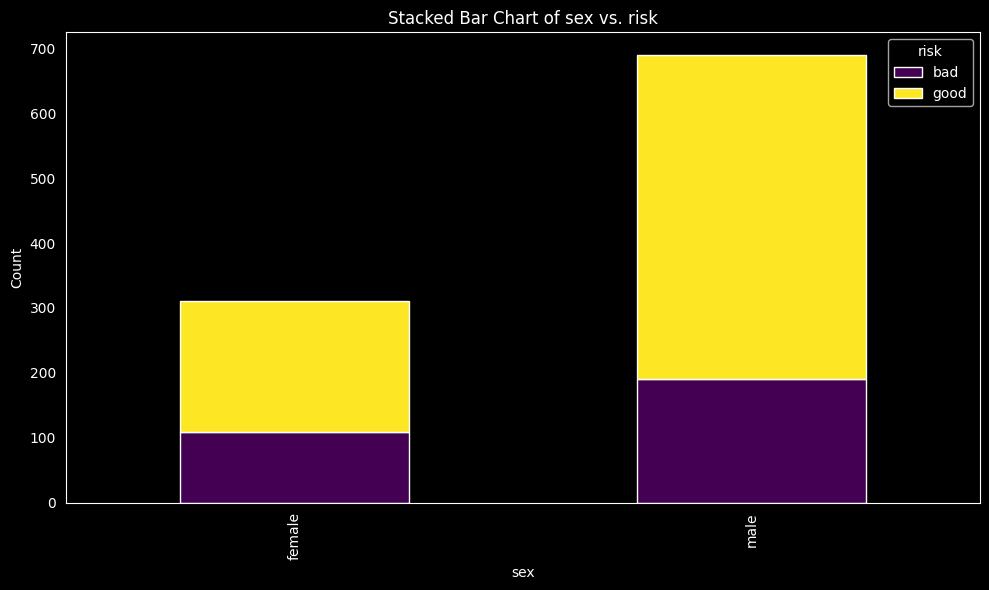

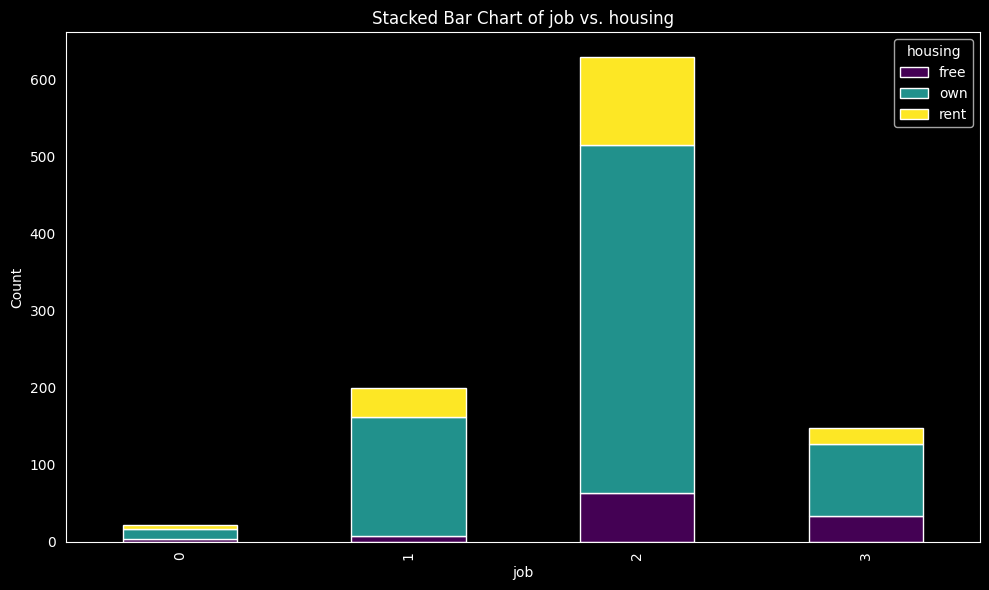

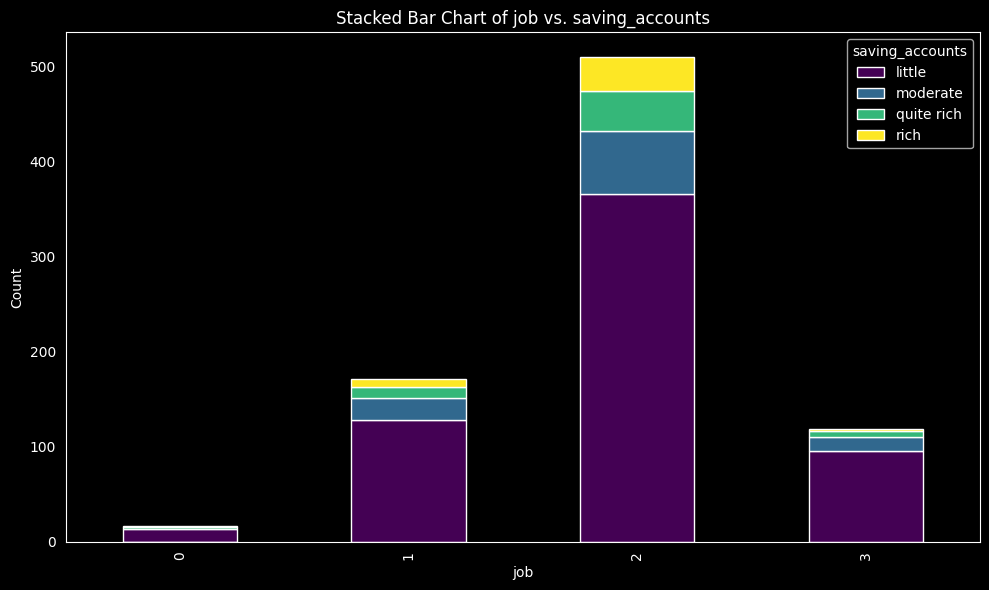

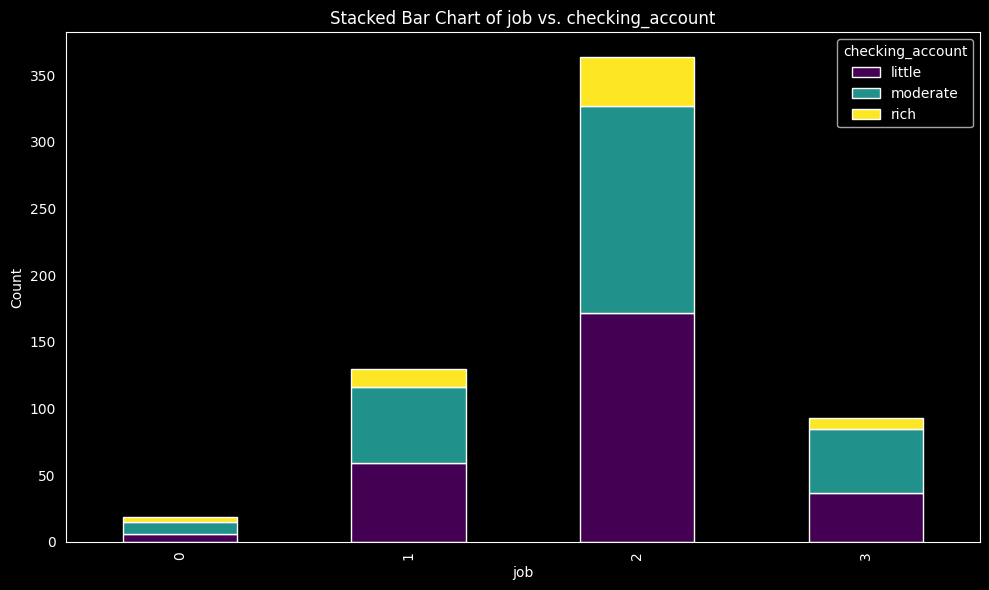

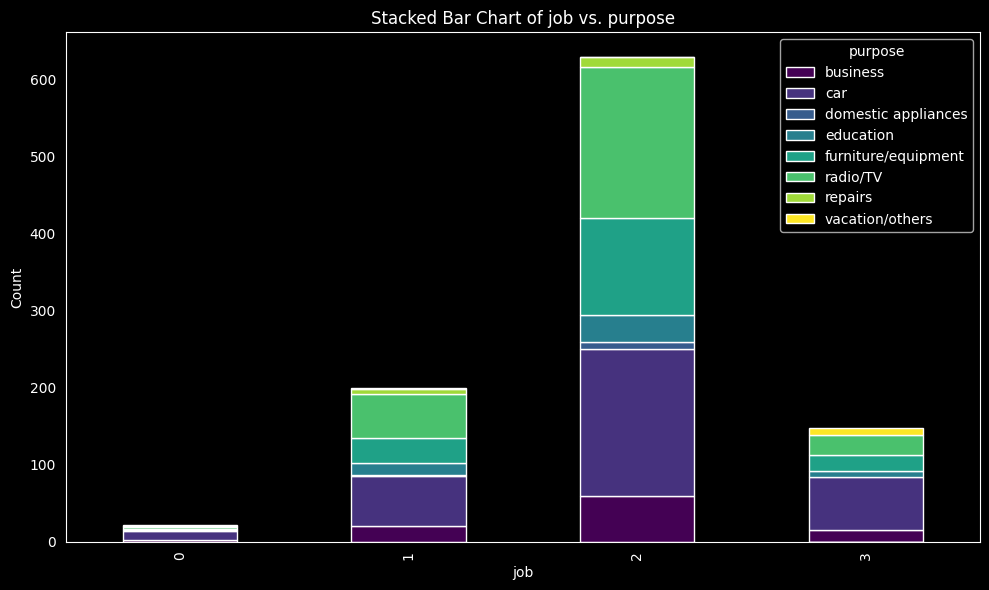

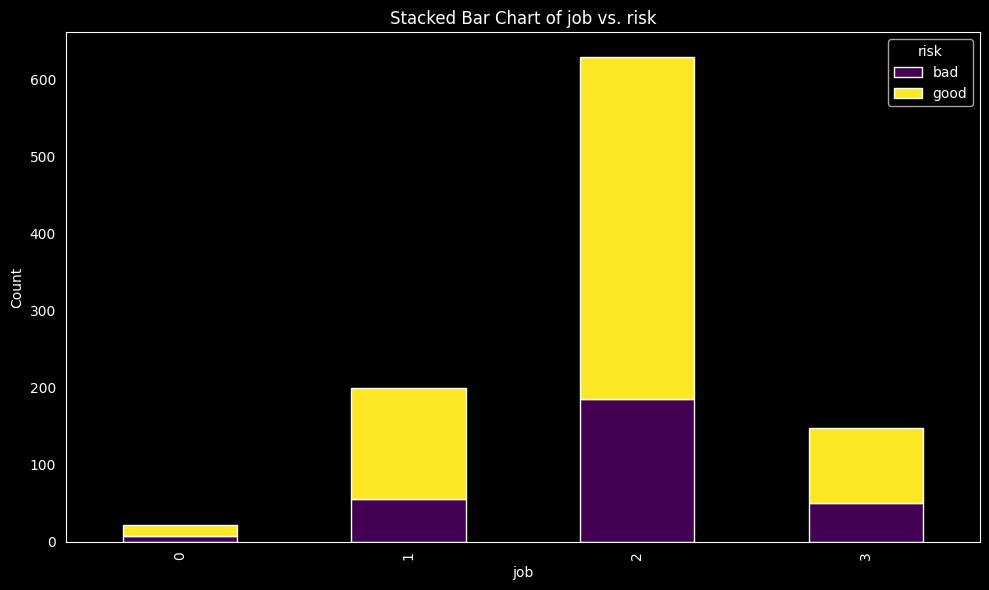

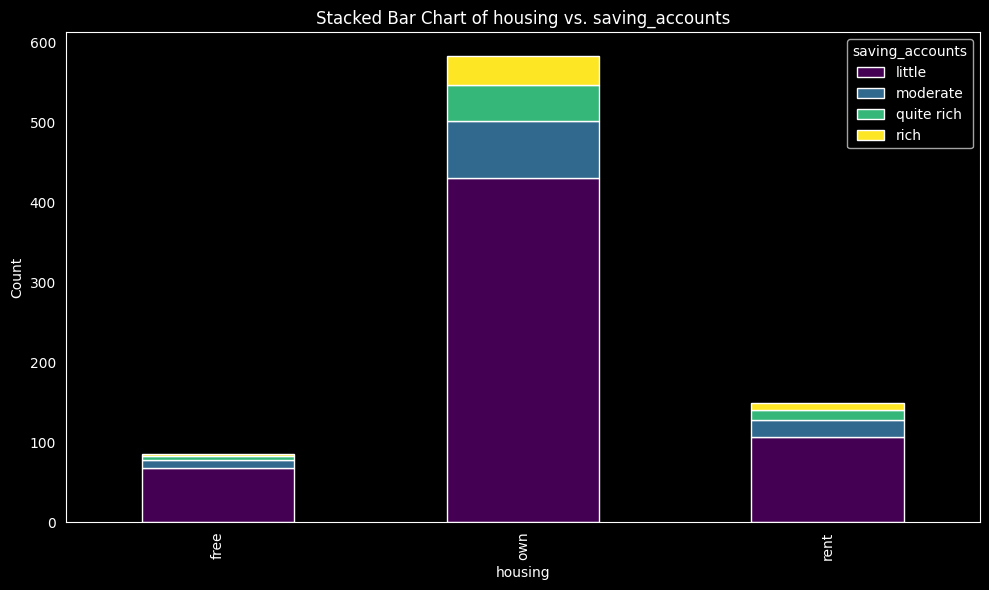

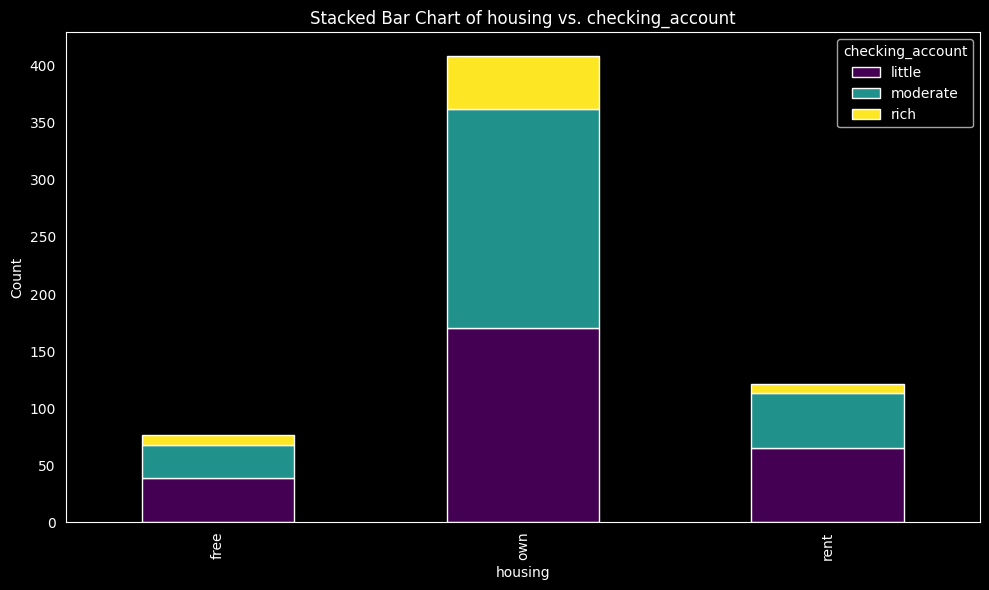

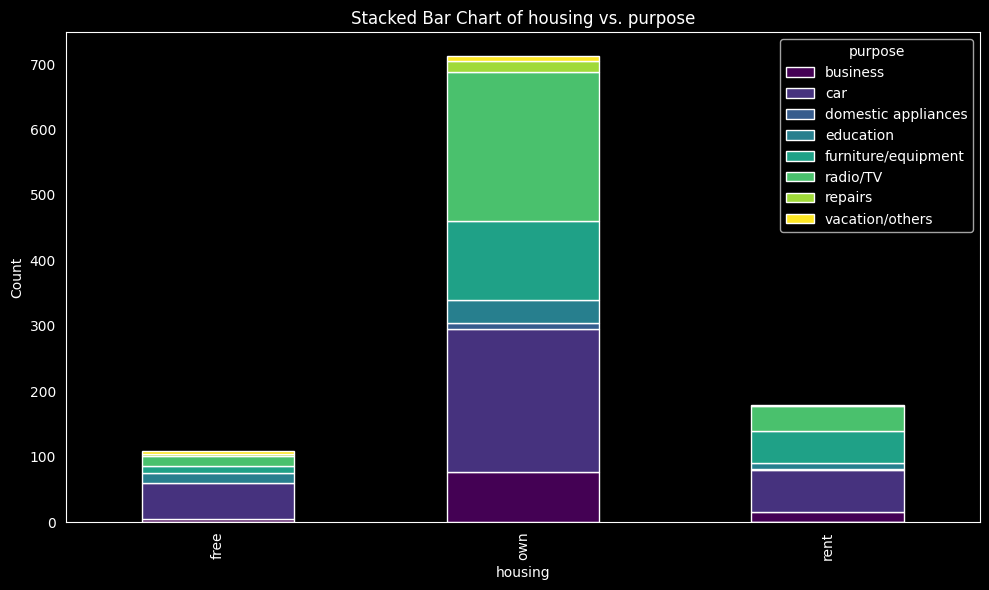

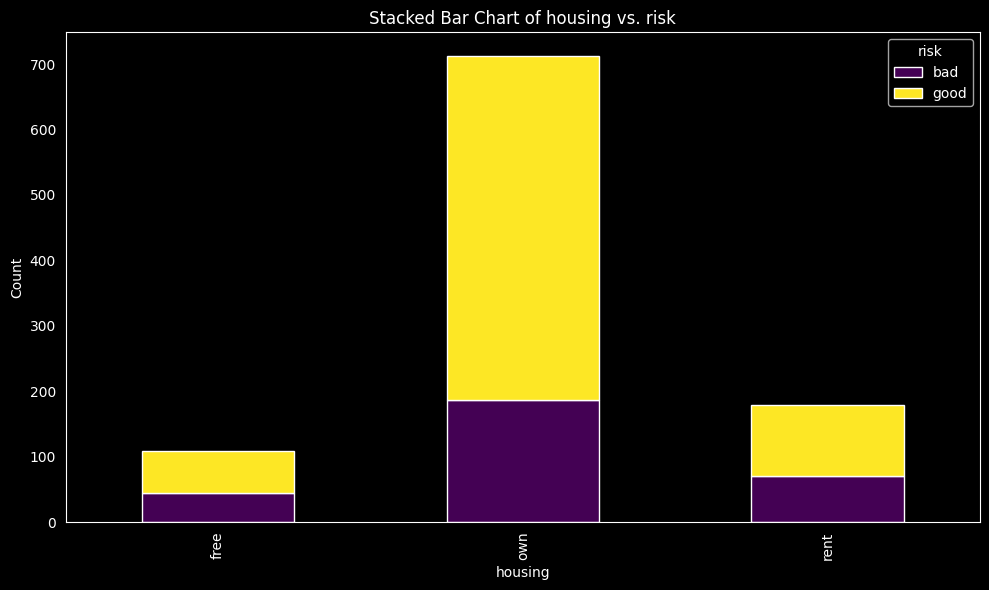

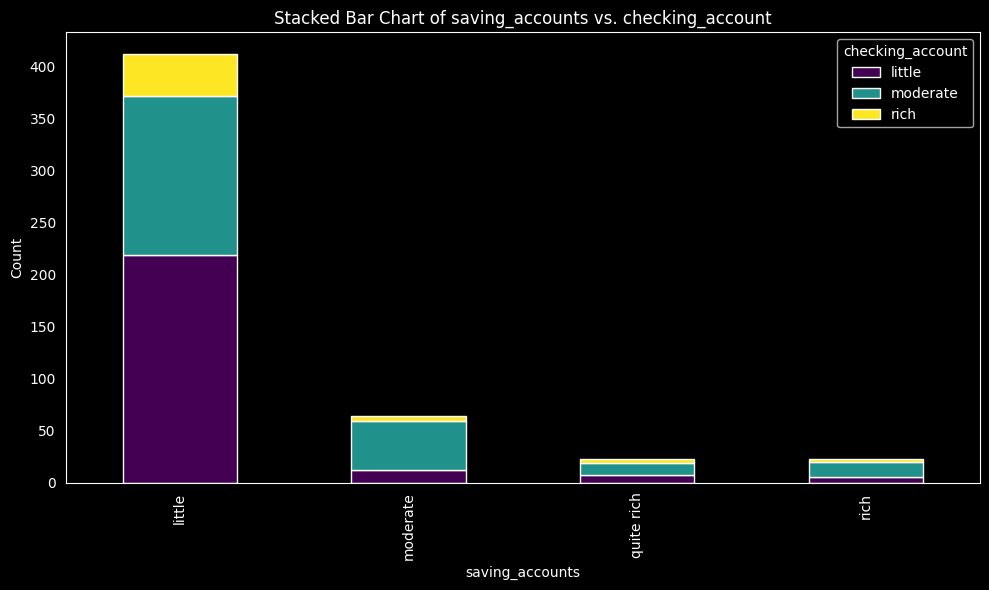

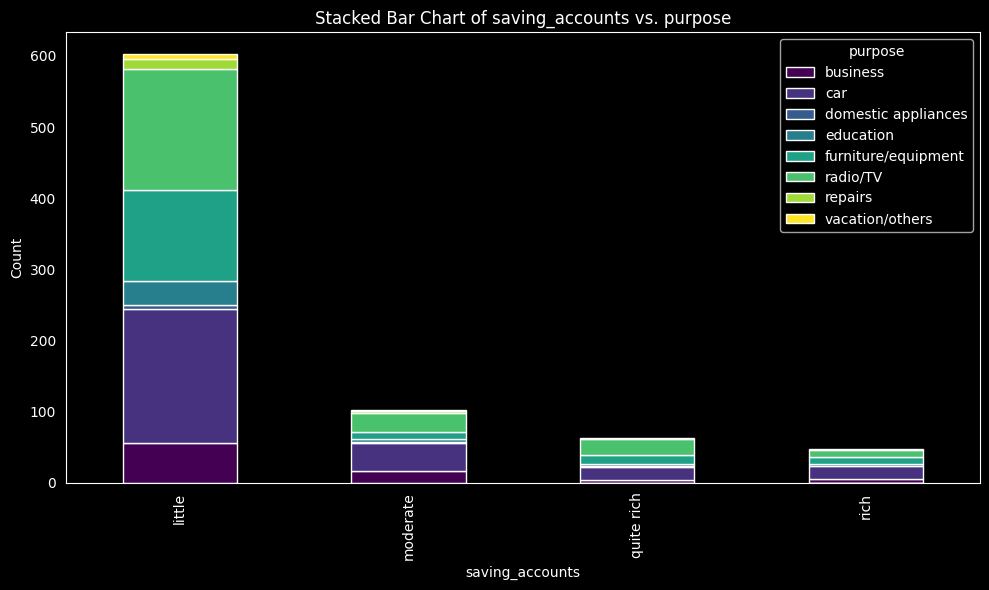

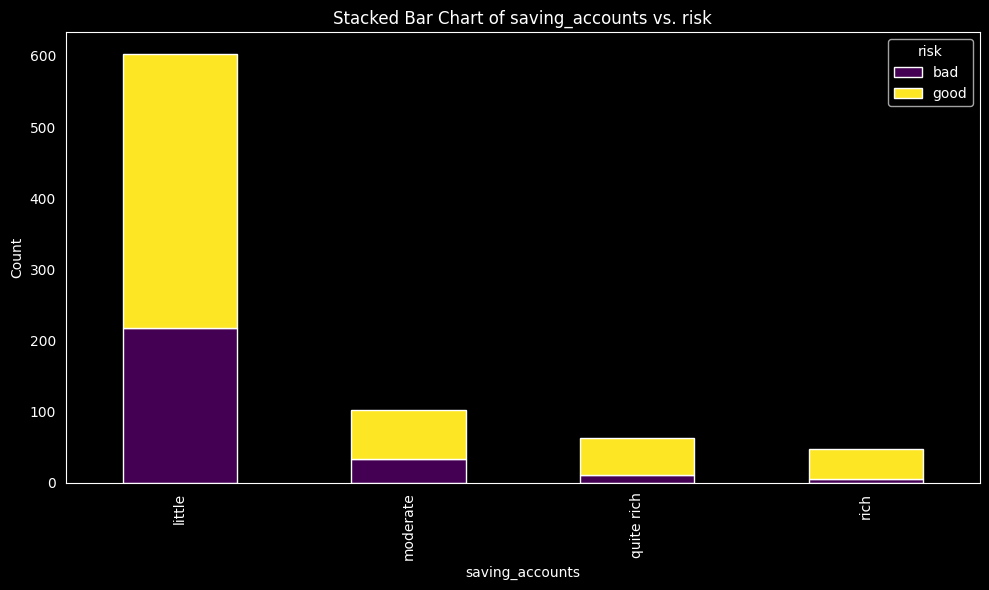

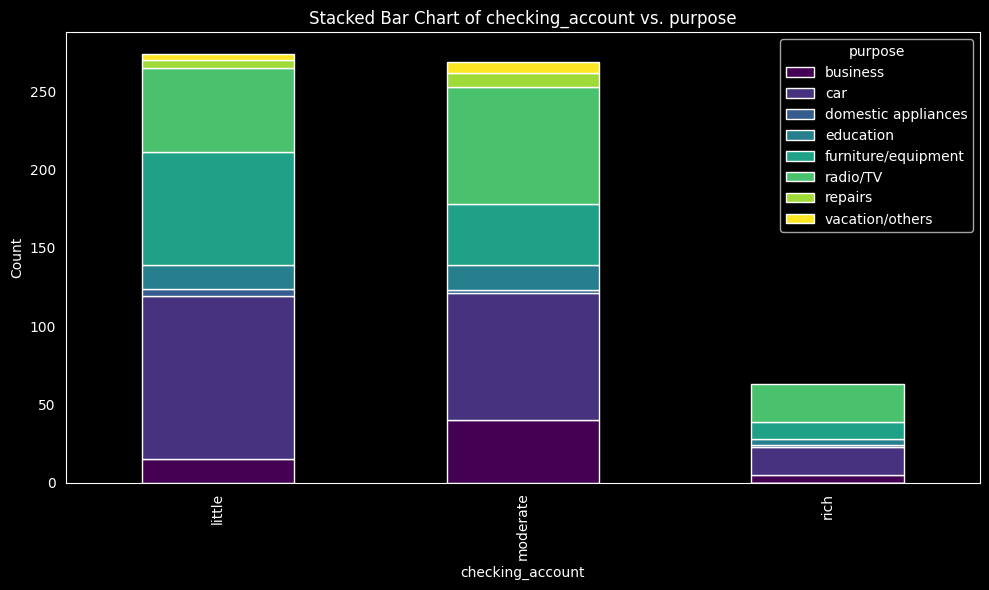

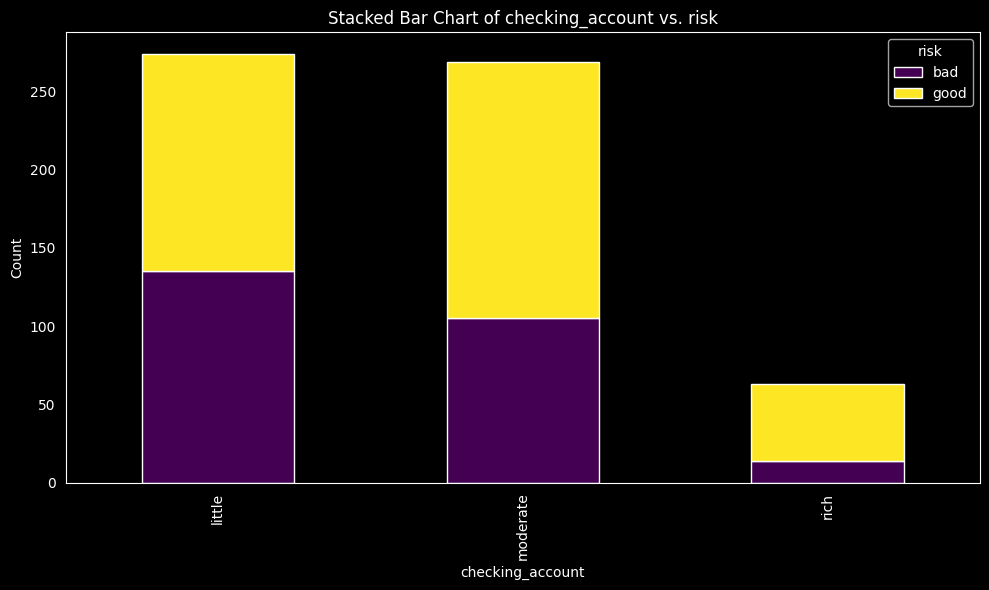

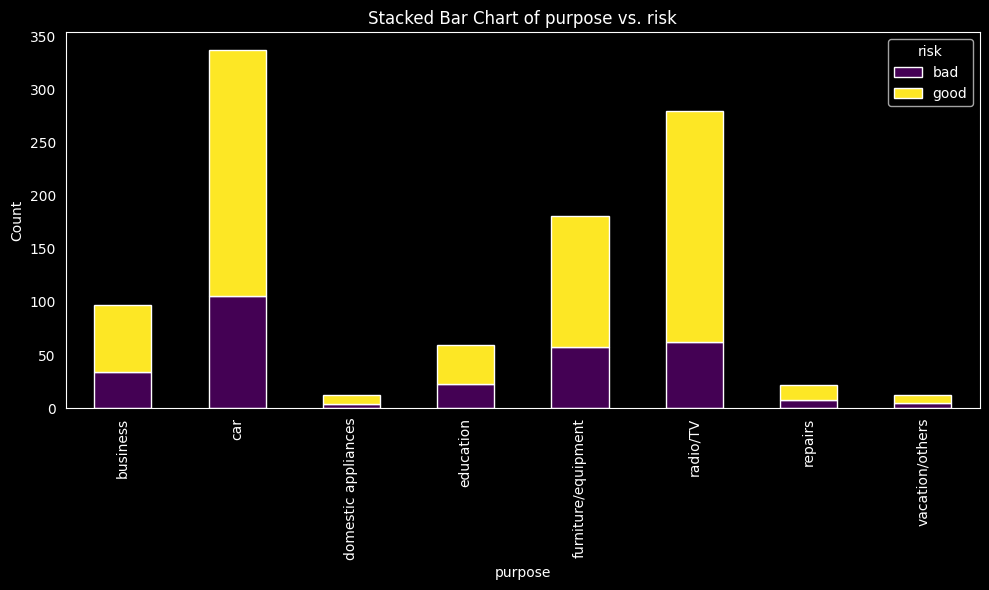

In [39]:
# Loop through all unique pairs of categorical variables
for cat_var1, cat_var2 in itertools.combinations(categorical_columns, 2):
    # Create a cross-tabulation of the two variables
    crosstab = pd.crosstab(df[cat_var1], df[cat_var2])
    
    # Plot a stacked bar chart
    crosstab.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="viridis")
    plt.title(f"Stacked Bar Chart of {cat_var1} vs. {cat_var2}")
    plt.xlabel(cat_var1)
    plt.ylabel("Count")
    plt.xticks(rotation=90)
    plt.legend(title=cat_var2)
    plt.tight_layout()
    plt.show()

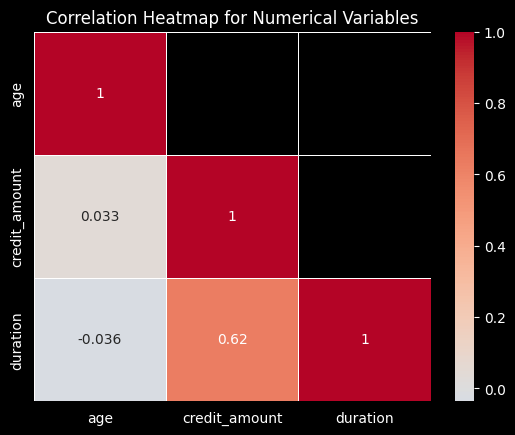

In [41]:
# Calculate the correlation matrix for numerical variables
correlation_matrix = df[numerical_columns].corr(method="pearson")

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    mask=mask,
    linewidths=0.7,
    center=0,
)
plt.title("Correlation Heatmap for Numerical Variables")
plt.show()